## 9) Loss functions: MSE + Gaussian NLL (for P_hat)

We combine them with **ReLoBRaLo** adaptive weights.

- Compute component losses: `L_mse`, `L_nll`.
- ReLoBRaLo assigns weights based on **relative progress** of each loss compared to a random lookback reference (initial vs previous),
  using an EMA-smoothed loss signal.
- We log `w_mse` and `w_nll` over training.

> This replaces the previous learnable log-variance weighting.

## 0) Imports & device
This cell imports dependencies and sets CPU/GPU device.


In [1]:

import math
import os
from dataclasses import dataclass
from typing import Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)


DEVICE: cuda


## 1) Configuration
All hyperparameters are grouped here for clarity.


In [2]:

@dataclass
class Config:
    # Dimensions
    nx: int = 3
    nth: int = 2
    ny: int = 2
    nz: int = 5  # nx+nth

    # Simulation
    dt: float = 0.1
    T: int = 200
    n_train: int = 256
    n_val: int = 64
    n_test: int = 128

    # Parameter step-change (single jump, then hold)
    jump_frac: float = 0.10
    jump_window: Tuple[int,int] = (60, 140)

    # True noises (for synthetic data)
    Qx_true_diag: Tuple[float,float,float] = (1e-4, 1e-4, 5e-5)
    R_true_diag: Tuple[float,float] = (2e-3, 2e-3)

    # Parameter random-walk base noise (relative to theta_ref)
    qth_base_rel: float = 1e-5

    # Jump detection via NIS (optional)
    jump_M: int = 2
    jump_J: int = 3
    nis_tau: float = 9.21  # chi2(df=2) 99%

    # Training
    epochs: int = 150
    batch_size: int = 32
    lr: float = 5e-3
    grad_clip: float = 1.0

    # UKN model
    gru_hidden: int = 32
    freeze_R_during_jump: bool = True

    # Jump logic toggle
    enable_jump_logic_train: bool = False
    enable_jump_logic_eval: bool = True

CFG = Config()
print(CFG)


Config(nx=3, nth=2, ny=2, nz=5, dt=0.1, T=200, n_train=256, n_val=64, n_test=128, jump_frac=0.1, jump_window=(60, 140), Qx_true_diag=(0.0001, 0.0001, 5e-05), R_true_diag=(0.002, 0.002), qth_base_rel=1e-05, jump_M=2, jump_J=3, nis_tau=9.21, epochs=150, batch_size=32, lr=0.005, grad_clip=1.0, gru_hidden=32, freeze_R_during_jump=True, enable_jump_logic_train=False, enable_jump_logic_eval=True)


## 2) Synthetic nonlinear system: f(x, θ), h(x)

Example system (replace with your own):
- State: `x=[p, v, b]`
- Parameters: `θ=[k, c]` (enter the **state dynamics**)
- Measurement: `y=[p + 0.1 b, v]`


In [3]:

def f_x_theta(x: torch.Tensor, th: torch.Tensor, dt: float) -> torch.Tensor:
    p, v, b = x[..., 0], x[..., 1], x[..., 2]
    k, c = th[..., 0], th[..., 1]

    p_next = p + dt * v
    v_next = v + dt * (-k * torch.sin(p) - c * v + 0.1 * torch.sin(b))
    b_next = b + dt * (0.05 * torch.cos(p))

    return torch.stack([p_next, v_next, b_next], dim=-1)

def h_x(x: torch.Tensor) -> torch.Tensor:
    p, v, b = x[..., 0], x[..., 1], x[..., 2]
    y1 = p + 0.1 * b
    y2 = v
    return torch.stack([y1, y2], dim=-1)


## 3) EKF Jacobians (augmented z=[x;θ])
EKF baseline needs Jacobians:
- `A = ∂f_aug/∂z` (5×5)
- `H = ∂h/∂z` (2×5)


In [4]:

def jacobian_A_aug(z: torch.Tensor, dt: float) -> torch.Tensor:
    p, v, b = z[..., 0], z[..., 1], z[..., 2]
    k, c = z[..., 3], z[..., 4]

    A = torch.zeros(z.shape[:-1] + (5, 5), device=z.device, dtype=z.dtype)

    # p_next = p + dt v
    A[..., 0, 0] = 1.0
    A[..., 0, 1] = dt

    # v_next = v + dt( -k sin(p) - c v + 0.1 sin(b) )
    A[..., 1, 0] = dt * (-k * torch.cos(p))
    A[..., 1, 1] = 1.0 + dt * (-c)
    A[..., 1, 2] = dt * (0.1 * torch.cos(b))
    A[..., 1, 3] = dt * (-torch.sin(p))
    A[..., 1, 4] = dt * (-v)

    # b_next = b + dt(0.05 cos(p))
    A[..., 2, 0] = dt * (-0.05 * torch.sin(p))
    A[..., 2, 2] = 1.0

    # theta random walk
    A[..., 3, 3] = 1.0
    A[..., 4, 4] = 1.0
    return A

def jacobian_H_aug(device=None, dtype=None) -> torch.Tensor:
    H = torch.zeros((2,5), dtype=dtype or torch.get_default_dtype(), device=device)
    H[0,0] = 1.0
    H[0,2] = 0.1
    H[1,1] = 1.0
    return H


## 4) Data generation (single step-change event in θ)
We simulate sequences where θ jumps once (±10%) at a random time within a window and then stays constant.


In [5]:

def simulate_dataset(cfg: Config, n_seq: int, seed: int = 0) -> Dict[str, np.ndarray]:
    rng = np.random.default_rng(seed)

    T = cfg.T
    dt = cfg.dt

    th_ref = np.array([1.0, 0.2], dtype=np.float64)

    Qx = np.diag(cfg.Qx_true_diag)
    R  = np.diag(cfg.R_true_diag)

    x_all = np.zeros((n_seq, T, cfg.nx), dtype=np.float64)
    th_all = np.zeros((n_seq, T, cfg.nth), dtype=np.float64)
    y_all = np.zeros((n_seq, T, cfg.ny), dtype=np.float64)
    jump_t_all = np.zeros((n_seq,), dtype=np.int64)

    for n in range(n_seq):
        x0 = np.array([0.2, 0.0, 0.1], dtype=np.float64) + rng.normal(0, 0.05, size=(cfg.nx,))
        th0 = th_ref * (1.0 + rng.normal(0, 0.03, size=(cfg.nth,)))

        t_jump = rng.integers(cfg.jump_window[0], cfg.jump_window[1])
        jump_t_all[n] = t_jump

        sign = rng.choice([-1.0, 1.0], size=(cfg.nth,))
        th_jump = th0 * (1.0 + sign * cfg.jump_frac)

        x = x0.copy()
        th = th0.copy()

        for t in range(T):
            if t == t_jump:
                th = th_jump.copy()

            x_t = torch.tensor(x, dtype=torch.float64)
            th_t = torch.tensor(th, dtype=torch.float64)
            x_next = f_x_theta(x_t, th_t, dt).cpu().numpy()
            x_next = x_next + rng.multivariate_normal(torch.zeros(cfg.nx), Qx)

            y = h_x(torch.tensor(x_next, dtype=torch.float64)).cpu().numpy()
            y = y + rng.multivariate_normal(torch.zeros(cfg.ny), R)

            x_all[n, t] = x_next
            th_all[n, t] = th
            y_all[n, t] = y

            x = x_next

    return {"x_true": x_all, "th_true": th_all, "y_meas": y_all, "jump_t": jump_t_all, "th_ref": th_ref}

train_data = simulate_dataset(CFG, CFG.n_train, seed=1)
val_data   = simulate_dataset(CFG, CFG.n_val, seed=2)
test_data  = simulate_dataset(CFG, CFG.n_test, seed=3)

print("train shapes:", train_data["x_true"].shape, train_data["y_meas"].shape)


C:\Users\minhy\AppData\Local\Temp\ipykernel_8620\2285431805.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_next = x_next + rng.multivariate_normal(torch.zeros(cfg.nx), Qx)
C:\Users\minhy\AppData\Local\Temp\ipykernel_8620\2285431805.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y = y + rng.multivariate_normal(torch.zeros(cfg.ny), R)


train shapes: (256, 200, 3) (256, 200, 2)


## 5) Robust UT helpers + SPD utilities

This section includes:
- Robust Cholesky with automatic jitter escalation.
- Sigma point generation.
- UT mean/cov and cross-cov.
- SPD construction from diagonal parameters.


In [6]:

def symmetrize(P: torch.Tensor) -> torch.Tensor:
    return 0.5 * (P + P.transpose(-1, -2))

def chol_psd(P: torch.Tensor, jitter: float = 1e-6, max_tries: int = 8) -> torch.Tensor:
    P = symmetrize(P)
    I = torch.eye(P.shape[-1], device=P.device, dtype=P.dtype)
    jit = jitter
    for _ in range(max_tries):
        try:
            return torch.linalg.cholesky(P + jit * I)
        except Exception:
            jit *= 10.0
    w, V = torch.linalg.eigh(P)
    w = torch.clamp(w, min=jitter)
    P_fix = V @ torch.diag_embed(w) @ V.transpose(-1, -2)
    return torch.linalg.cholesky(P_fix + jitter * I)

def inv_via_cholesky(S: torch.Tensor) -> torch.Tensor:
    L = chol_psd(S)
    I = torch.eye(S.shape[-1], device=S.device, dtype=S.dtype).expand(S.shape[0], -1, -1)
    return torch.cholesky_solve(I, L)

def spd_from_diag(raw: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    s = torch.nn.functional.softplus(raw) + eps
    return torch.diag_embed(s**2)

def sigma_points(mean: torch.Tensor, cov: torch.Tensor, gamma: float) -> torch.Tensor:
    if mean.dim() == 1:
        mean = mean.unsqueeze(0)
        cov = cov.unsqueeze(0)
        squeeze = True
    else:
        squeeze = False
    B, n = mean.shape
    S = gamma * chol_psd(cov)
    Xi0 = mean.unsqueeze(1)
    cols = S.transpose(-1, -2)
    Xi = torch.cat([Xi0, Xi0 + cols, Xi0 - cols], dim=1)
    return Xi.squeeze(0) if squeeze else Xi

def ut_weights(n: int, alpha: float = 1e-3, beta: float = 2.0, kappa: float = 0.0):
    lam = alpha**2 * (n + kappa) - n
    c = n + lam
    Wm = torch.full((2*n+1,), 0.5/c, dtype=torch.get_default_dtype(), device=DEVICE)
    Wc = torch.full((2*n+1,), 0.5/c, dtype=torch.get_default_dtype(), device=DEVICE)
    Wm[0] = lam / c
    Wc[0] = lam / c + (1 - alpha**2 + beta)
    gamma = math.sqrt(c)
    return Wm, Wc, gamma

def ut_mean_cov(Xi: torch.Tensor, Wm: torch.Tensor, Wc: torch.Tensor):
    mean = (Xi * Wm.view(1, -1, 1)).sum(dim=1)
    d = Xi - mean.unsqueeze(1)
    cov = torch.einsum("bln,blm,l->bnm", d, d, Wc)
    return mean, symmetrize(cov)

def ut_cross_cov(Xi: torch.Tensor, Yi: torch.Tensor, x_mean: torch.Tensor, y_mean: torch.Tensor, Wc: torch.Tensor):
    dx = Xi - x_mean.unsqueeze(1)
    dy = Yi - y_mean.unsqueeze(1)
    return torch.einsum("bln,blm,l->bnm", dx, dy, Wc)


## 6) EKF-aug baseline
EKF uses Jacobians to propagate covariance.


In [7]:

@torch.no_grad()
def ekf_aug_run(cfg: Config, y: torch.Tensor, z0: torch.Tensor, P0: torch.Tensor,
                Qx: torch.Tensor, R: torch.Tensor, th_ref: torch.Tensor,
                enable_jump_logic: bool = True):
    B, T, _ = y.shape
    H = jacobian_H_aug(device=y.device, dtype=y.dtype)

    QxB = Qx.unsqueeze(0).expand(B, -1, -1) if Qx.dim() == 2 else Qx
    RB  = R.unsqueeze(0).expand(B, -1, -1)  if R.dim() == 2 else R

    z, P = z0, P0
    z_out, P_out = [], []

    consec = torch.zeros((B,), device=y.device, dtype=torch.int64)
    jump_count = torch.zeros((B,), device=y.device, dtype=torch.int64)

    sigma_base = cfg.qth_base_rel * th_ref.abs()
    Qth_base = torch.diag_embed(sigma_base**2).unsqueeze(0).expand(B, -1, -1)
    sigma_jump = (cfg.jump_frac / math.sqrt(cfg.jump_J)) * th_ref.abs()
    Qth_jump = torch.diag_embed(sigma_jump**2).unsqueeze(0).expand(B, -1, -1)

    I5 = torch.eye(cfg.nz, device=y.device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)
    I2 = torch.eye(cfg.ny, device=y.device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)

    for t in range(T):
        x = z[:, :3]
        th = z[:, 3:]
        x_pred = f_x_theta(x, th, cfg.dt)
        z_pred = torch.cat([x_pred, th], dim=-1)

        A = jacobian_A_aug(z, cfg.dt)

        Qth = Qth_base
        if enable_jump_logic:
            Qth = torch.where(jump_count.view(B,1,1) > 0, Qth_jump, Qth_base)

        Q_aug = torch.zeros((B,5,5), device=y.device, dtype=y.dtype)
        Q_aug[:, :3, :3] = QxB
        Q_aug[:, 3:, 3:] = Qth

        P_pred = A @ P @ A.transpose(-1,-2) + Q_aug
        P_pred = symmetrize(P_pred) + 1e-9 * I5

        y_pred = h_x(x_pred)
        e = y[:, t] - y_pred

        S = symmetrize(H @ P_pred @ H.transpose(-1,-2) + RB) + 1e-9 * I2
        Sinv = inv_via_cholesky(S)

        K = P_pred @ H.transpose(-1,-2) @ Sinv
        z = z_pred + torch.einsum("bmn,bn->bm", K, e)

        KH = K @ H
        P = (I5 - KH) @ P_pred @ (I5 - KH).transpose(-1,-2) + K @ RB @ K.transpose(-1,-2)
        P = symmetrize(P) + 1e-9 * I5

        if enable_jump_logic:
            nis = torch.einsum("bi,bij,bj->b", e, Sinv, e)
            exceed = nis > cfg.nis_tau
            consec = torch.where(exceed, consec + 1, torch.zeros_like(consec))
            trigger = consec >= cfg.jump_M
            jump_count = torch.where(trigger, torch.full_like(jump_count, cfg.jump_J), jump_count)
            consec = torch.where(trigger, torch.zeros_like(consec), consec)
            jump_count = torch.clamp(jump_count - 1, min=0)

        z_out.append(z); P_out.append(P)

    return torch.stack(z_out, dim=1), torch.stack(P_out, dim=1)


## 7) UKF-aug baseline
Uses the standard UKF covariance update: `P = P_pred - K S K^T`.


In [8]:

@torch.no_grad()
def ukf_aug_run(cfg: Config, y: torch.Tensor, z0: torch.Tensor, P0: torch.Tensor,
                Qx: torch.Tensor, R: torch.Tensor, th_ref: torch.Tensor,
                enable_jump_logic: bool = True,
                ut_alpha: float = 1e-3, ut_beta: float = 2.0, ut_kappa: float = 0.0):
    B, T, _ = y.shape
    n = cfg.nz
    Wm, Wc, gamma = ut_weights(n, alpha=ut_alpha, beta=ut_beta, kappa=ut_kappa)
    Wm, Wc = Wm.to(y.device), Wc.to(y.device)

    QxB = Qx.unsqueeze(0).expand(B, -1, -1) if Qx.dim() == 2 else Qx
    RB  = R.unsqueeze(0).expand(B, -1, -1)  if R.dim() == 2 else R

    z, P = z0, P0
    z_out, P_out = [], []

    consec = torch.zeros((B,), device=y.device, dtype=torch.int64)
    jump_count = torch.zeros((B,), device=y.device, dtype=torch.int64)

    sigma_base = cfg.qth_base_rel * th_ref.abs()
    Qth_base = torch.diag_embed(sigma_base**2).unsqueeze(0).expand(B, -1, -1)
    sigma_jump = (cfg.jump_frac / math.sqrt(cfg.jump_J)) * th_ref.abs()
    Qth_jump = torch.diag_embed(sigma_jump**2).unsqueeze(0).expand(B, -1, -1)

    I5 = torch.eye(cfg.nz, device=y.device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)
    I2 = torch.eye(cfg.ny, device=y.device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)

    for t in range(T):
        Xi = sigma_points(z, P, gamma)
        Xi_x, Xi_th = Xi[..., :3], Xi[..., 3:]
        X_pred = f_x_theta(Xi_x, Xi_th, cfg.dt)
        Zi_pred = torch.cat([X_pred, Xi_th], dim=-1)

        z_pred, P_pred_noQ = ut_mean_cov(Zi_pred, Wm, Wc)

        Qth = Qth_base
        if enable_jump_logic:
            Qth = torch.where(jump_count.view(B,1,1) > 0, Qth_jump, Qth_base)

        Q_aug = torch.zeros((B,5,5), device=y.device, dtype=y.dtype)
        Q_aug[:, :3, :3] = QxB
        Q_aug[:, 3:, 3:] = Qth

        P_pred = symmetrize(P_pred_noQ + Q_aug) + 1e-9 * I5

        Yi = h_x(Zi_pred[..., :3])
        y_pred, S_noR = ut_mean_cov(Yi, Wm, Wc)
        Pzy = ut_cross_cov(Zi_pred, Yi, z_pred, y_pred, Wc)

        S = symmetrize(S_noR + RB) + 1e-9 * I2
        Sinv = inv_via_cholesky(S)
        K = torch.einsum("bmn,bnk->bmk", Pzy, Sinv)

        e = y[:, t] - y_pred
        z = z_pred + torch.einsum("bmn,bn->bm", K, e)

        P = symmetrize(P_pred - K @ S @ K.transpose(-1, -2)) + 1e-9 * I5

        if enable_jump_logic:
            nis = torch.einsum("bi,bij,bj->b", e, Sinv, e)
            exceed = nis > cfg.nis_tau
            consec = torch.where(exceed, consec + 1, torch.zeros_like(consec))
            trigger = consec >= cfg.jump_M
            jump_count = torch.where(trigger, torch.full_like(jump_count, cfg.jump_J), jump_count)
            consec = torch.where(trigger, torch.zeros_like(consec), consec)
            jump_count = torch.clamp(jump_count - 1, min=0)

        z_out.append(z); P_out.append(P)

    return torch.stack(z_out, dim=1), torch.stack(P_out, dim=1)


## 8) UKN model: UKF backbone + learnable Qx + GRU-adaptive Rt


In [9]:

class UKN(nn.Module):
    def __init__(self, cfg: Config, th_ref: np.ndarray):
        super().__init__()
        self.cfg = cfg

        self.qx_raw = nn.Parameter(torch.zeros(cfg.nx, dtype=torch.get_default_dtype()))

        self.gru = nn.GRU(input_size=11, hidden_size=cfg.gru_hidden, batch_first=True)
        self.head_R = nn.Linear(cfg.gru_hidden, cfg.ny)

        self.uR0 = nn.Parameter(torch.zeros(cfg.ny, dtype=torch.get_default_dtype()))

        th_ref_t = torch.tensor(th_ref, device=DEVICE, dtype=torch.get_default_dtype())
        self.register_buffer("th_ref", th_ref_t)

        Wm, Wc, gamma = ut_weights(cfg.nz, alpha=1e-3, beta=2.0, kappa=0.0)
        self.register_buffer("Wm", Wm)
        self.register_buffer("Wc", Wc)
        self.gamma = gamma

    def Qx(self, B: int, device) -> torch.Tensor:
        return spd_from_diag(self.qx_raw).to(device).unsqueeze(0).expand(B, -1, -1)

    def Qtheta_base_jump(self, B: int, device):
        sigma_base = self.cfg.qth_base_rel * self.th_ref.abs()
        Qth_base = torch.diag_embed(sigma_base**2).to(device).unsqueeze(0).expand(B, -1, -1)
        sigma_jump = (self.cfg.jump_frac / math.sqrt(self.cfg.jump_J)) * self.th_ref.abs()
        Qth_jump = torch.diag_embed(sigma_jump**2).to(device).unsqueeze(0).expand(B, -1, -1)
        return Qth_base, Qth_jump

    def forward(self, y: torch.Tensor, z0: torch.Tensor, P0: torch.Tensor, enable_jump_logic: bool = True):
        cfg = self.cfg
        device = y.device
        B, T, _ = y.shape
        Wm, Wc = self.Wm.to(device), self.Wc.to(device)
        gamma = self.gamma

        QxB = self.Qx(B, device)
        Qth_base, Qth_jump = self.Qtheta_base_jump(B, device)

        z, P = z0, P0
        uR = self.uR0.to(device).unsqueeze(0).expand(B, -1)
        h = torch.zeros((1, B, cfg.gru_hidden), device=device, dtype=y.dtype)

        consec = torch.zeros((B,), device=device, dtype=torch.int64)
        jump_count = torch.zeros((B,), device=device, dtype=torch.int64)

        e_prev = torch.zeros((B, cfg.ny), device=device, dtype=y.dtype)

        z_list, P_list = [], []
        Rt_diag_list, duR_list, uR_list, nis_list, jc_list = [], [], [], [], []

        I5 = torch.eye(cfg.nz, device=device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)
        I2 = torch.eye(cfg.ny, device=device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)

        for t in range(T):
            Xi = sigma_points(z, P, gamma)
            Xi_x, Xi_th = Xi[..., :3], Xi[..., 3:]
            X_pred = f_x_theta(Xi_x, Xi_th, cfg.dt)
            Zi_pred = torch.cat([X_pred, Xi_th], dim=-1)
            z_pred, P_pred_noQ = ut_mean_cov(Zi_pred, Wm, Wc)

            Qth = Qth_base
            if enable_jump_logic:
                Qth = torch.where(jump_count.view(B,1,1) > 0, Qth_jump, Qth_base)

            Q_aug = torch.zeros((B,5,5), device=device, dtype=y.dtype)
            Q_aug[:, :3, :3] = QxB
            Q_aug[:, 3:, 3:] = Qth
            P_pred = symmetrize(P_pred_noQ + Q_aug) + 1e-9 * I5

            Yi = h_x(Zi_pred[..., :3])
            y_pred, S_noR = ut_mean_cov(Yi, Wm, Wc)
            Pzy = ut_cross_cov(Zi_pred, Yi, z_pred, y_pred, Wc)

            e = y[:, t] - y_pred
            de = e - e_prev
            e_prev = e

            diagP_pred_x = torch.diagonal(P_pred[:, :3, :3], dim1=-2, dim2=-1)
            diagS_noR = torch.diagonal(S_noR, dim1=-2, dim2=-1)
            feat = torch.cat([e, de, e.abs(), diagP_pred_x, diagS_noR], dim=-1)

            out, h = self.gru(feat.unsqueeze(1), h)
            duR = self.head_R(out.squeeze(1))

            if cfg.freeze_R_during_jump and enable_jump_logic:
                duR = torch.where((jump_count > 0).unsqueeze(-1), torch.zeros_like(duR), duR)

            uR = uR + duR
            uR = torch.clamp(uR, min=-20.0, max=20.0)

            R_t = spd_from_diag(uR)
            Rt_diag_list.append(torch.diagonal(R_t, dim1=-2, dim2=-1))
            duR_list.append(duR)
            uR_list.append(uR)

            S = symmetrize(S_noR + R_t) + 1e-9 * I2
            Sinv = inv_via_cholesky(S)
            K = torch.einsum("bmn,bnk->bmk", Pzy, Sinv)

            z = z_pred + torch.einsum("bmn,bn->bm", K, e)
            P = symmetrize(P_pred - K @ S @ K.transpose(-1, -2)) + 1e-9 * I5

            nis = torch.einsum("bi,bij,bj->b", e, Sinv, e)
            nis_list.append(nis)
            jc_list.append(jump_count)

            if enable_jump_logic:
                exceed = nis > cfg.nis_tau
                consec = torch.where(exceed, consec + 1, torch.zeros_like(consec))
                trigger = consec >= cfg.jump_M
                jump_count = torch.where(trigger, torch.full_like(jump_count, cfg.jump_J), jump_count)
                consec = torch.where(trigger, torch.zeros_like(consec), consec)
                jump_count = torch.clamp(jump_count - 1, min=0)

            z_list.append(z); P_list.append(P)

        return {
            "z_filt": torch.stack(z_list, dim=1),
            "P_filt": torch.stack(P_list, dim=1),
            "Rt_diag": torch.stack(Rt_diag_list, dim=1),
            "duR": torch.stack(duR_list, dim=1),
            "uR": torch.stack(uR_list, dim=1),
            "nis": torch.stack(nis_list, dim=1),
            "jump_count": torch.stack(jc_list, dim=1),
        }


## 9) Loss functions: MSE + Gaussian NLL (for P_hat)

We combine them with adaptive learnable weights:
`Loss = exp(-s1)*MSE + s1 + exp(-s2)*NLL + s2`


In [10]:
def gaussian_nll(z_true: torch.Tensor, z_hat: torch.Tensor, P_hat: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    # Mean Gaussian NLL over batch/time for z ~ N(z_hat, P_hat)
    B, T, D = z_true.shape
    I = torch.eye(D, device=z_true.device, dtype=z_true.dtype).view(1,1,D,D)

    P = symmetrize(P_hat) + eps * I
    e = (z_true - z_hat).unsqueeze(-1)

    P2 = P.reshape(B*T, D, D)
    e2 = e.reshape(B*T, D, 1)

    L2 = chol_psd(P2, jitter=eps)
    sol2 = torch.cholesky_solve(e2, L2)
    quad2 = (e2.transpose(-1,-2) @ sol2).squeeze(-1).squeeze(-1)

    logdet2 = 2.0 * torch.log(torch.diagonal(L2, dim1=-2, dim2=-1)).sum(-1)
    const = D * math.log(2.0 * math.pi)
    nll2 = 0.5 * (logdet2 + quad2 + const)

    return nll2.mean()


class ReLoBRaLo:
    # ReLoBRaLo-style adaptive loss weighting for K losses.
    # - Maintains EMA-smoothed losses.
    # - Uses random lookback reference: initial (L0) vs previous (L_prev).
    # - Weights ∝ (EMA / ref)^alpha, normalized so sum=K.
    def __init__(self, K: int, alpha: float = 1.0, ema: float = 0.99, eps: float = 1e-12, p_lookback_init: float = 0.5):
        self.K = K
        self.alpha = alpha
        self.ema = ema
        self.eps = eps
        self.p_init = p_lookback_init

        self.L0 = None
        self.L_prev = None
        self.L_ema = None

    @torch.no_grad()
    def update(self, losses: torch.Tensor) -> torch.Tensor:
        # losses: (K,) tensor (detached). returns: (K,) weights
        if self.L0 is None:
            self.L0 = losses.clone()
            self.L_prev = losses.clone()
            self.L_ema = losses.clone()

        # EMA update
        self.L_ema = self.ema * self.L_ema + (1.0 - self.ema) * losses

        # random lookback
        if torch.rand((), device=losses.device) < self.p_init:
            ref = self.L0
        else:
            ref = self.L_prev

        ratio = self.L_ema / (ref + self.eps)
        w = ratio.pow(self.alpha)

        # normalize: sum = K
        w = self.K * w / (w.sum() + self.eps)

        # update previous snapshot
        self.L_prev = self.L_ema.clone()
        return w

## 10) Training utilities (batching + init)


In [11]:

def to_torch_batch(batch_np: Dict[str, np.ndarray], idx: np.ndarray, device=DEVICE):
    x = torch.tensor(batch_np["x_true"][idx], device=device)
    th = torch.tensor(batch_np["th_true"][idx], device=device)
    y = torch.tensor(batch_np["y_meas"][idx], device=device)
    z_true = torch.cat([x, th], dim=-1)
    return y, z_true

def init_filter_states(cfg: Config, B: int, th_ref: np.ndarray, device=DEVICE):
    x0 = torch.zeros((B, cfg.nx), device=device, dtype=torch.get_default_dtype())
    th0 = torch.tensor(th_ref, device=device, dtype=torch.get_default_dtype()).unsqueeze(0).expand(B, -1)
    z0 = torch.cat([x0, th0], dim=-1)
    P0 = torch.diag_embed(
        torch.tensor([0.5, 0.5, 0.5, 0.2, 0.2], device=device, dtype=torch.get_default_dtype())**2
    ).expand(B, -1, -1)
    return z0, P0


## 11) Train UKN with ReLoBRaLo adaptive weights

We train UKN using two supervised objectives:
- **MSE** on the filtered augmented state `z=[x;θ]`
- **Gaussian NLL** using the filter covariance `P`

**ReLoBRaLo** updates weights every mini-batch based on relative progress (EMA / random lookback).
We log:
- total training loss (weighted)
- component losses (MSE, NLL)
- adaptive weights `w_mse`, `w_nll`

In [12]:
ukn = UKN(CFG, train_data["th_ref"]).to(DEVICE)

# ReLoBRaLo hyperparameters (tune if needed)
RELOB_ALPHA = 1.0
RELOB_EMA   = 0.99
RELOB_P_INIT = 0.5  # probability of using initial loss as lookback reference

relobalo = ReLoBRaLo(K=2, alpha=RELOB_ALPHA, ema=RELOB_EMA, p_lookback_init=RELOB_P_INIT)

opt = optim.Adam(ukn.parameters(), lr=CFG.lr)

train_loss_hist, val_loss_hist = [], []
mse_hist, nll_hist = [], []
w_mse_hist, w_nll_hist = [], []

for epoch in range(1, CFG.epochs + 1):
    ukn.train()
    perm = np.random.permutation(CFG.n_train)

    epoch_loss = 0.0
    epoch_mse = 0.0
    epoch_nll = 0.0
    epoch_wmse = 0.0
    epoch_wnll = 0.0
    nbatch = 0

    for i0 in range(0, CFG.n_train, CFG.batch_size):
        idx = perm[i0:i0+CFG.batch_size]
        B = len(idx)

        y_b, z_true_b = to_torch_batch(train_data, idx, device=DEVICE)
        z0, P0 = init_filter_states(CFG, B, train_data["th_ref"], device=DEVICE)

        out = ukn(y_b, z0, P0, enable_jump_logic=CFG.enable_jump_logic_train)
        z_hat = out["z_filt"]
        P_hat = out["P_filt"]

        L_mse = torch.mean((z_hat - z_true_b)**2)
        L_nll = gaussian_nll(z_true_b, z_hat, P_hat, eps=1e-6)

        # ReLoBRaLo weights (no-grad)
        with torch.no_grad():
            w = relobalo.update(torch.stack([L_mse.detach(), L_nll.detach()]))
        w_mse_t, w_nll_t = w[0], w[1]

        loss = w_mse_t * L_mse + w_nll_t * L_nll

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(ukn.parameters(), CFG.grad_clip)
        opt.step()

        epoch_loss += float(loss.detach().cpu())
        epoch_mse  += float(L_mse.detach().cpu())
        epoch_nll  += float(L_nll.detach().cpu())
        epoch_wmse += float(w_mse_t.detach().cpu())
        epoch_wnll += float(w_nll_t.detach().cpu())
        nbatch += 1

    # epoch averages
    train_loss_hist.append(epoch_loss / max(nbatch, 1))
    mse_hist.append(epoch_mse / max(nbatch, 1))
    nll_hist.append(epoch_nll / max(nbatch, 1))
    w_mse_epoch = epoch_wmse / max(nbatch, 1)
    w_nll_epoch = epoch_wnll / max(nbatch, 1)
    w_mse_hist.append(w_mse_epoch)
    w_nll_hist.append(w_nll_epoch)

    # validation (no weight-state updates; use epoch-average weights)
    ukn.eval()
    with torch.no_grad():
        permv = np.random.permutation(CFG.n_val)
        vloss, vb = 0.0, 0
        for j0 in range(0, CFG.n_val, CFG.batch_size):
            idx = permv[j0:j0+CFG.batch_size]
            B = len(idx)

            y_b, z_true_b = to_torch_batch(val_data, idx, device=DEVICE)
            z0, P0 = init_filter_states(CFG, B, val_data["th_ref"], device=DEVICE)

            out = ukn(y_b, z0, P0, enable_jump_logic=CFG.enable_jump_logic_train)
            z_hat = out["z_filt"]
            P_hat = out["P_filt"]

            L_mse = torch.mean((z_hat - z_true_b)**2)
            L_nll = gaussian_nll(z_true_b, z_hat, P_hat, eps=1e-6)

            loss = w_mse_epoch * L_mse + w_nll_epoch * L_nll
            vloss += float(loss.detach().cpu())
            vb += 1

        val_loss_hist.append(vloss / max(vb, 1))

    if epoch % 5 == 0 or epoch == 1:
        print(f"epoch {epoch:03d} | train {train_loss_hist[-1]:.6e} | val {val_loss_hist[-1]:.6e} | "
              f"w_mse {w_mse_hist[-1]:.3e} w_nll {w_nll_hist[-1]:.3e}")

epoch 001 | train 3.432922e+00 | val 2.885618e+00 | w_mse 1.002e+00 w_nll 9.977e-01
epoch 005 | train 2.494676e+00 | val 2.421036e+00 | w_mse 1.031e+00 w_nll 9.695e-01
epoch 010 | train 1.865272e+00 | val 1.792515e+00 | w_mse 1.106e+00 w_nll 8.942e-01
epoch 015 | train 1.312508e+00 | val 1.241673e+00 | w_mse 1.128e+00 w_nll 8.720e-01
epoch 020 | train 7.776353e-01 | val 7.064850e-01 | w_mse 1.082e+00 w_nll 9.178e-01
epoch 025 | train 1.905011e-01 | val 1.209654e-01 | w_mse 1.108e+00 w_nll 8.920e-01
epoch 030 | train -3.350474e-01 | val -3.975070e-01 | w_mse 1.204e+00 w_nll 7.956e-01
epoch 035 | train -8.779913e-01 | val -9.319247e-01 | w_mse 1.192e+00 w_nll 8.083e-01
epoch 040 | train -1.254647e-01 | val -1.354667e-01 | w_mse 1.880e+00 w_nll 1.198e-01
epoch 045 | train 4.303508e+01 | val 4.268455e+01 | w_mse 2.696e+01 w_nll -2.496e+01
epoch 050 | train -4.633030e+00 | val -4.749551e+00 | w_mse -2.191e-01 w_nll 2.219e+00
epoch 055 | train -6.229541e+00 | val -6.360016e+00 | w_mse -3.698

## 12) Test evaluation + save results
Saves to a local file in the current working directory (Windows-friendly).


In [13]:

ukn.eval()

y_test = torch.tensor(test_data["y_meas"], device=DEVICE)
x_true = torch.tensor(test_data["x_true"], device=DEVICE)
th_true = torch.tensor(test_data["th_true"], device=DEVICE)
z_true = torch.cat([x_true, th_true], dim=-1)

Btest = y_test.shape[0]
z0, P0 = init_filter_states(CFG, Btest, test_data["th_ref"], device=DEVICE)

Qx_true = torch.diag(torch.tensor(CFG.Qx_true_diag, device=DEVICE, dtype=torch.get_default_dtype()))
R_true  = torch.diag(torch.tensor(CFG.R_true_diag, device=DEVICE, dtype=torch.get_default_dtype()))
th_ref_t = torch.tensor(test_data["th_ref"], device=DEVICE, dtype=torch.get_default_dtype())

z_ekf, P_ekf = ekf_aug_run(CFG, y_test, z0, P0, Qx_true, R_true, th_ref_t, enable_jump_logic=CFG.enable_jump_logic_eval)
z_ukf, P_ukf = ukf_aug_run(CFG, y_test, z0, P0, Qx_true, R_true, th_ref_t, enable_jump_logic=CFG.enable_jump_logic_eval)

with torch.no_grad():
    out_ukn = ukn(y_test, z0, P0, enable_jump_logic=CFG.enable_jump_logic_eval)
    z_ukn, P_ukn = out_ukn["z_filt"], out_ukn["P_filt"]
    Rt_diag = out_ukn["Rt_diag"]
    duR = out_ukn["duR"]
    uR = out_ukn["uR"]
    nis = out_ukn["nis"]
    jump_count = out_ukn["jump_count"]

Z995 = 2.5758293035489004
diag_cov = lambda P: torch.diagonal(P, dim1=-2, dim2=-1)

e_ekf = z_ekf - z_true
e_ukf = z_ukf - z_true
e_ukn = z_ukn - z_true

ci_ekf = Z995 * torch.sqrt(torch.clamp(diag_cov(P_ekf), min=1e-12))
ci_ukf = Z995 * torch.sqrt(torch.clamp(diag_cov(P_ukf), min=1e-12))
ci_ukn = Z995 * torch.sqrt(torch.clamp(diag_cov(P_ukn), min=1e-12))

rmse_t_ekf = torch.sqrt(torch.mean(e_ekf**2, dim=(0,2)))
rmse_t_ukf = torch.sqrt(torch.mean(e_ukf**2, dim=(0,2)))
rmse_t_ukn = torch.sqrt(torch.mean(e_ukn**2, dim=(0,2)))

RESULTS_PATH = os.path.join(os.getcwd(), "ukn_augmented_stepchange_results_with_adaptive_weights.npz")
np.savez(
    RESULTS_PATH,
    train_loss=np.array(train_loss_hist),
    val_loss=np.array(val_loss_hist),
    mse=np.array(mse_hist),
    nll=np.array(nll_hist),
    w_mse=np.array(w_mse_hist),
    w_nll=np.array(w_nll_hist),

    z_true=z_true.detach().cpu().numpy(),
    z_ekf=z_ekf.detach().cpu().numpy(),
    z_ukf=z_ukf.detach().cpu().numpy(),
    z_ukn=z_ukn.detach().cpu().numpy(),

    ci_ekf=ci_ekf.detach().cpu().numpy(),
    ci_ukf=ci_ukf.detach().cpu().numpy(),
    ci_ukn=ci_ukn.detach().cpu().numpy(),

    rmse_t_ekf=rmse_t_ekf.detach().cpu().numpy(),
    rmse_t_ukf=rmse_t_ukf.detach().cpu().numpy(),
    rmse_t_ukn=rmse_t_ukn.detach().cpu().numpy(),

    jump_t=test_data["jump_t"],

    Rt_diag=Rt_diag.detach().cpu().numpy(),
    duR=duR.detach().cpu().numpy(),
    uR=uR.detach().cpu().numpy(),
    nis=nis.detach().cpu().numpy(),
    jump_count=jump_count.detach().cpu().numpy(),
)
print("Saved results to:", RESULTS_PATH)


Saved results to: c:\Users\minhy\Documents\Research\Unscented-KalmanNet\ukn_augmented_stepchange_results_with_adaptive_weights.npz


## 13) FINAL: Plotting
Includes:
- Training curve
- ReLoBRaLo adaptive weights
- Estimate vs True (one sequence)
- Method-wise error + 99% CI (subplots)
- RMSE over time (direct comparison)
- UKN Rt diagnostics


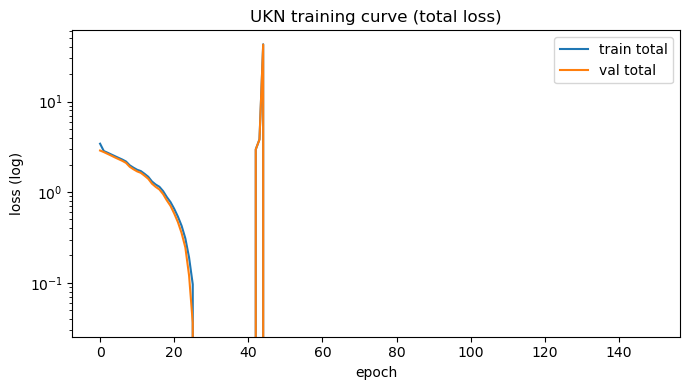

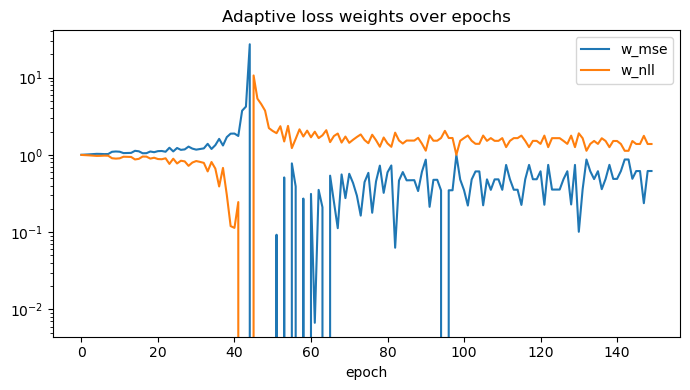

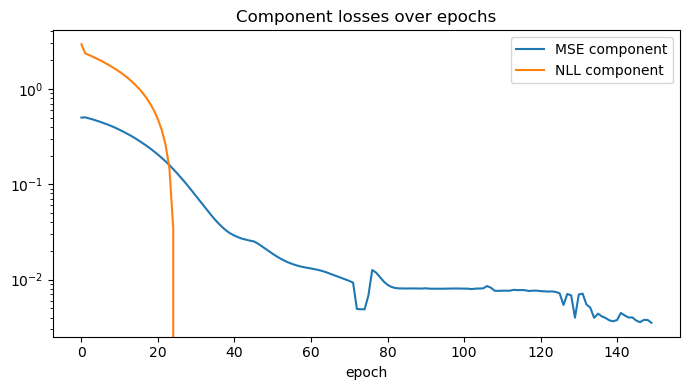

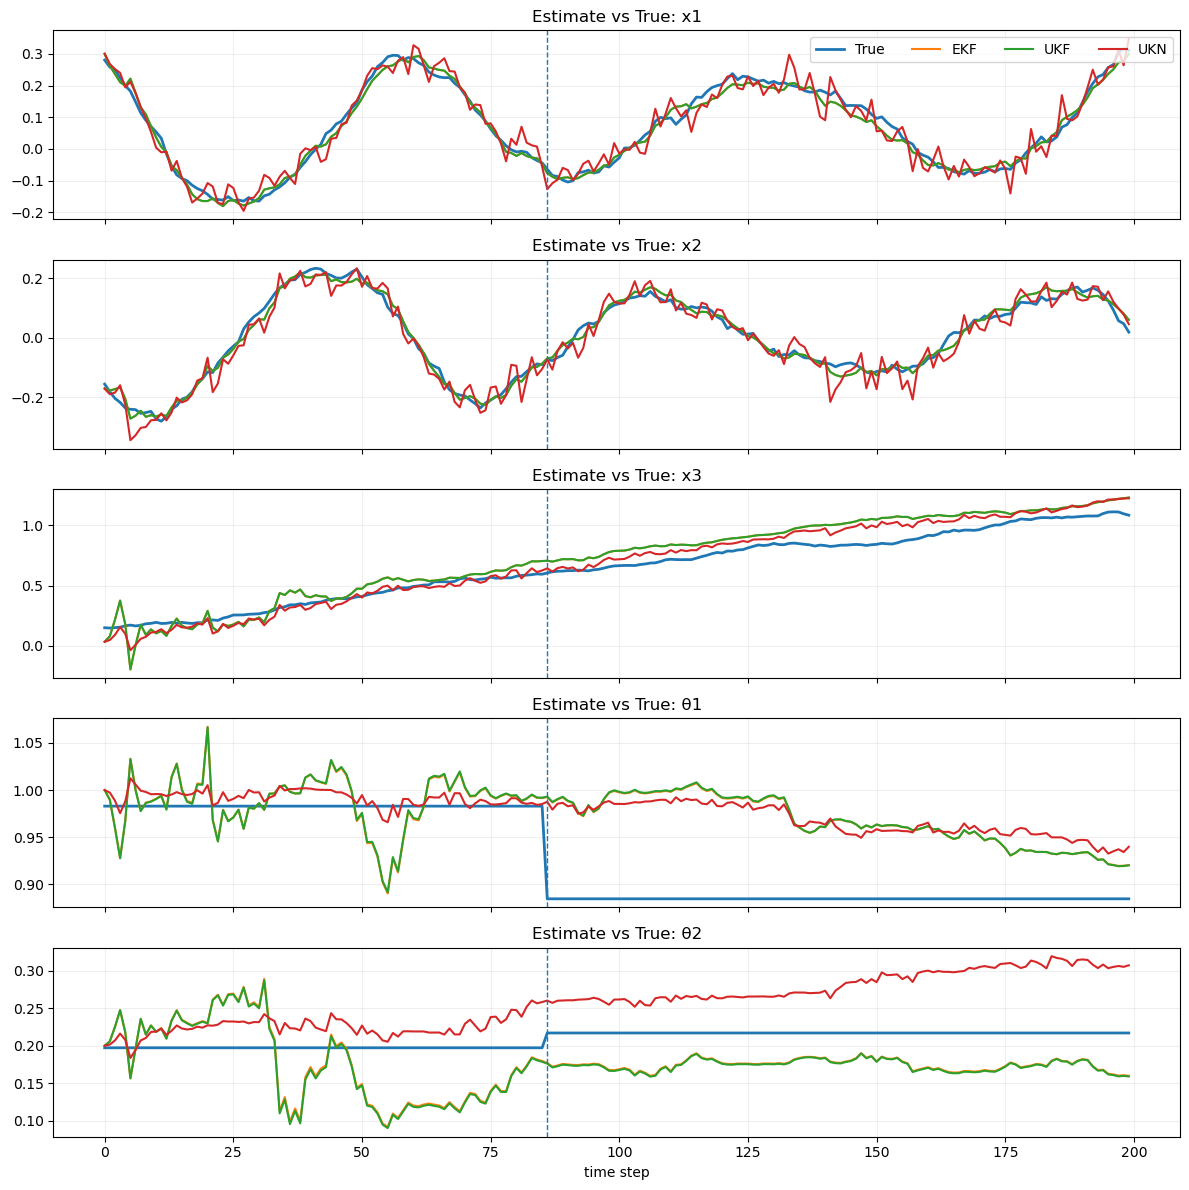

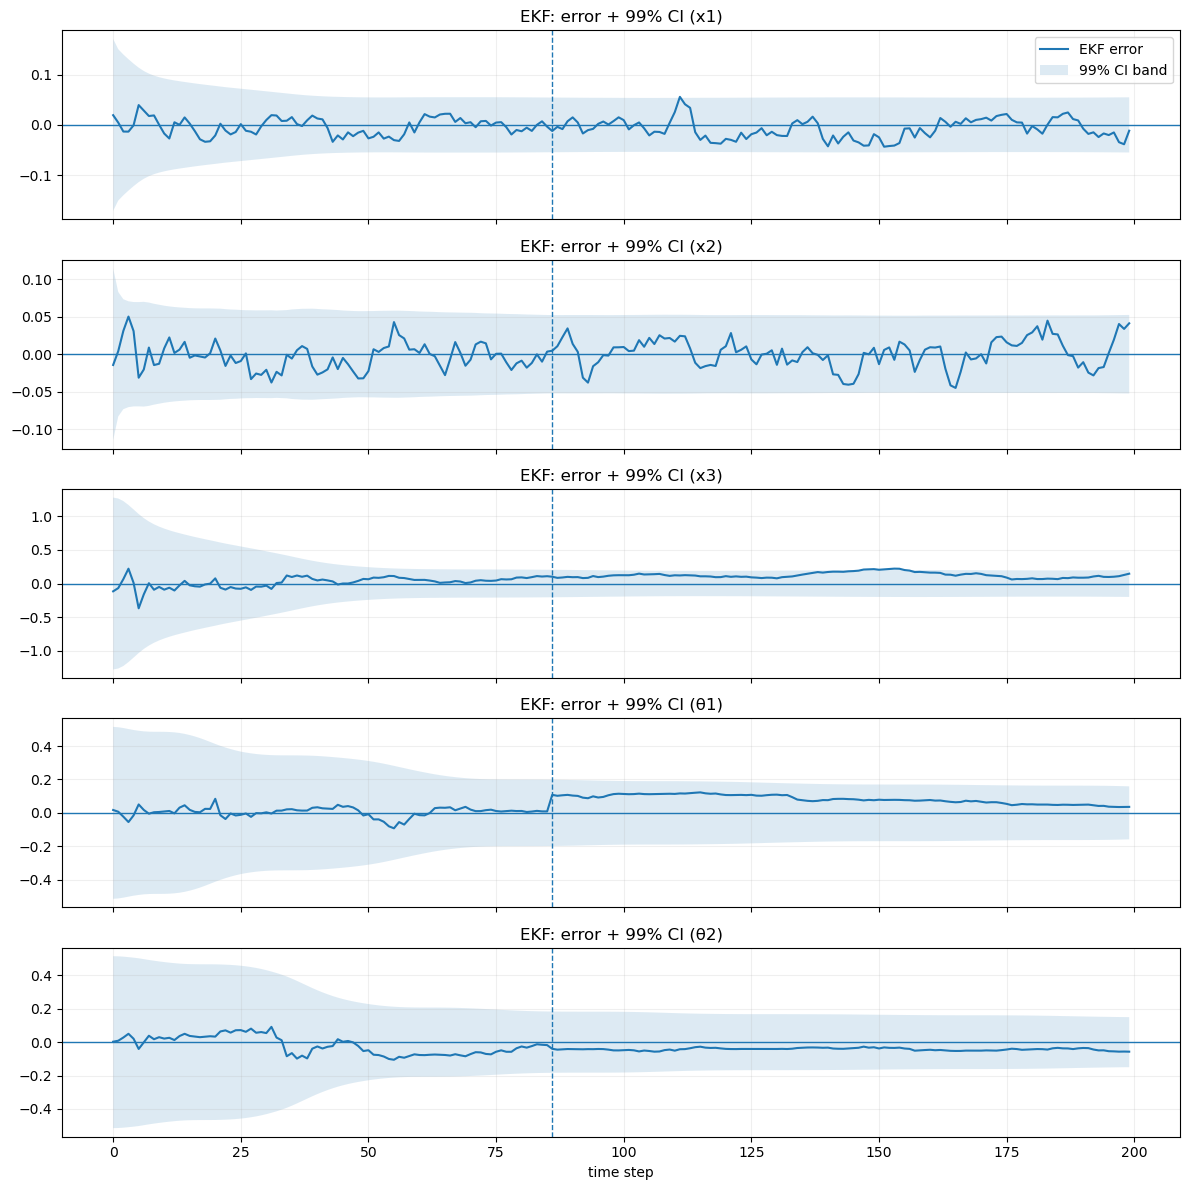

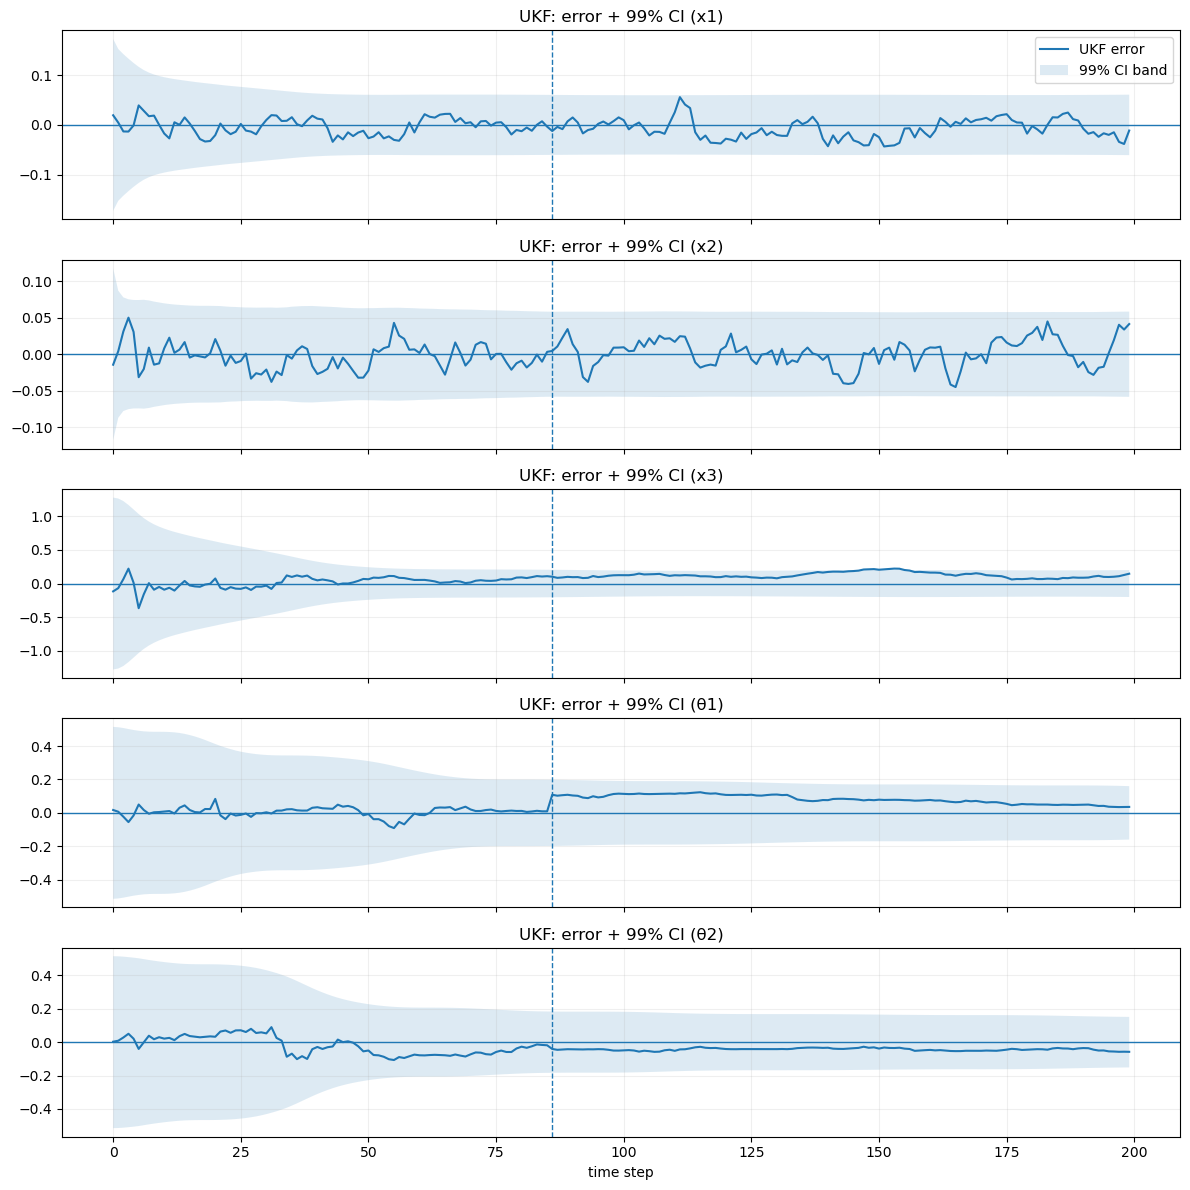

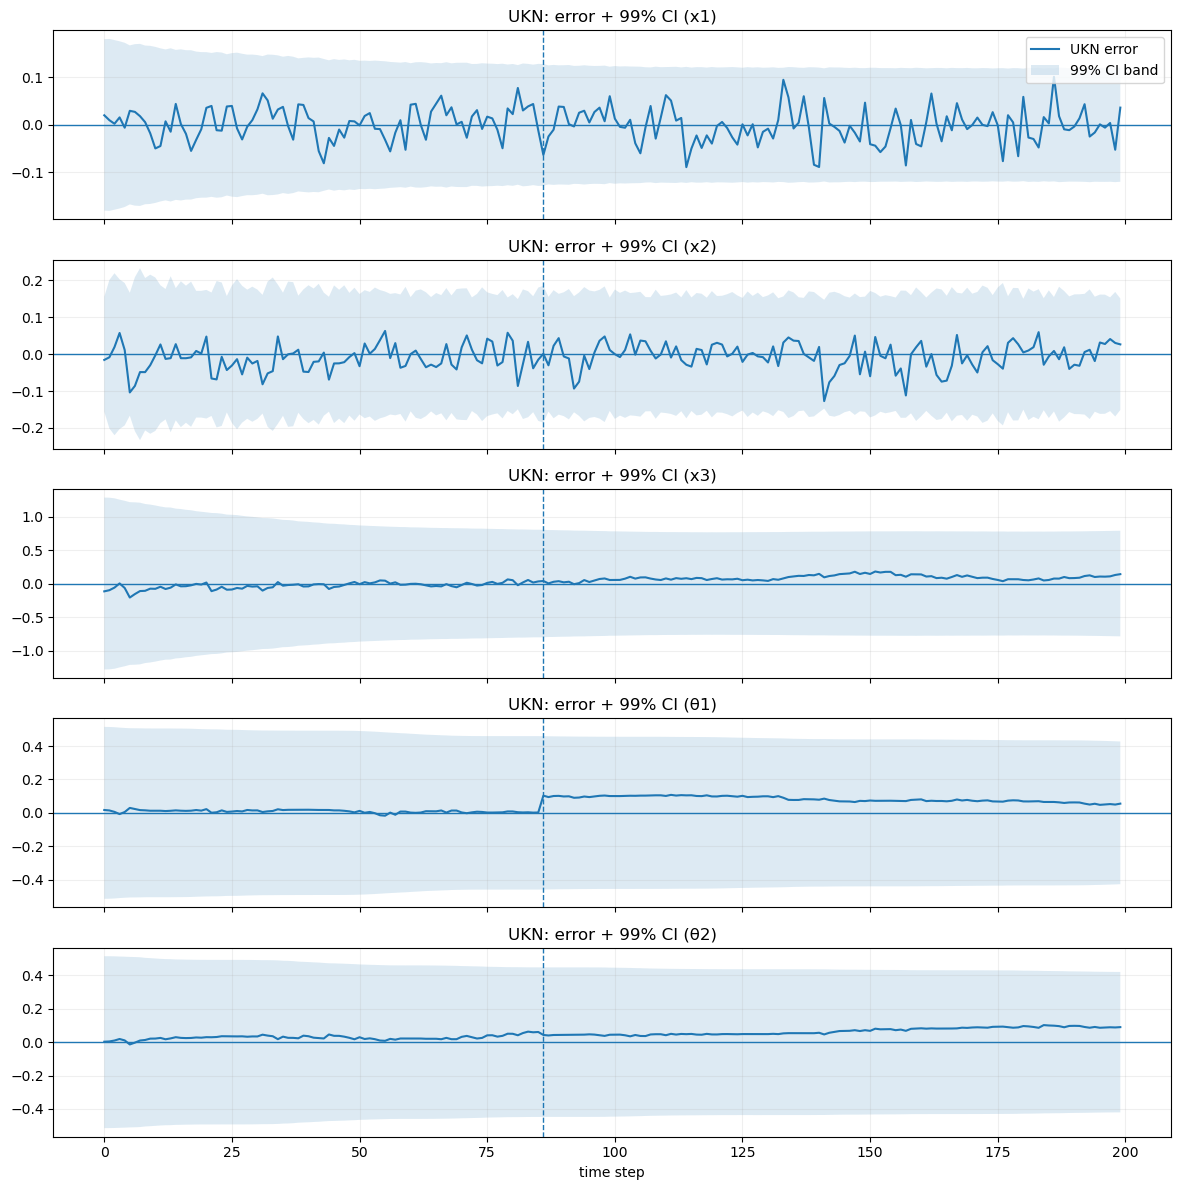

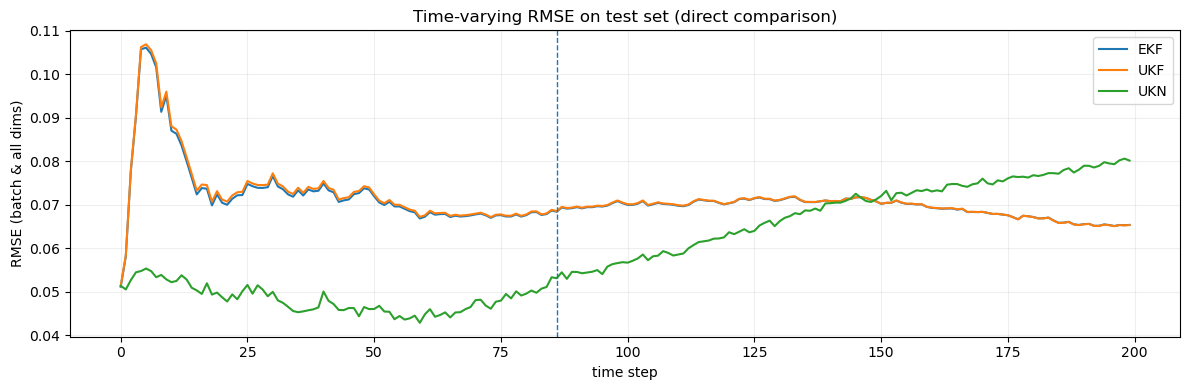

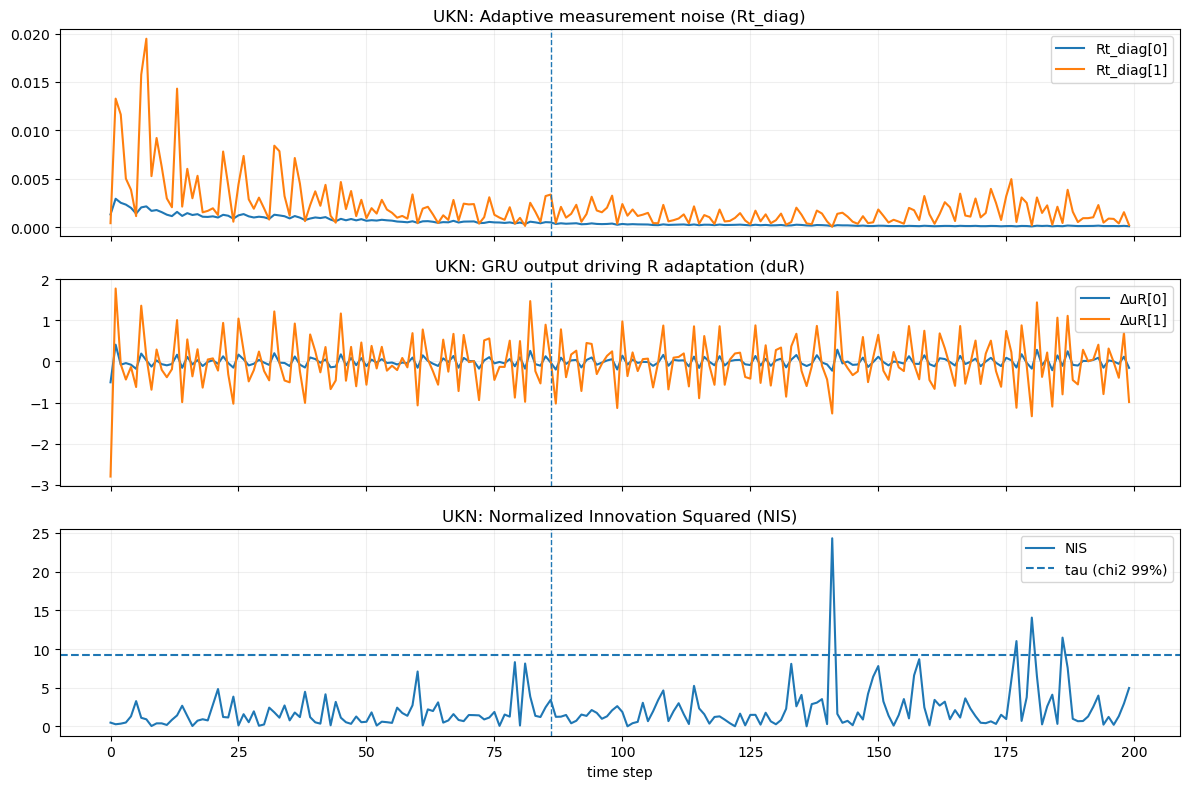

In [14]:

data = np.load(RESULTS_PATH, allow_pickle=True)

train_loss = data["train_loss"]
val_loss = data["val_loss"]
mse_hist = data["mse"]
nll_hist = data["nll"]
w_mse = data["w_mse"]
w_nll = data["w_nll"]

z_true = data["z_true"]
z_ekf  = data["z_ekf"]
z_ukf  = data["z_ukf"]
z_ukn  = data["z_ukn"]

ci_ekf = data["ci_ekf"]
ci_ukf = data["ci_ukf"]
ci_ukn = data["ci_ukn"]

rmse_t_ekf = data["rmse_t_ekf"]
rmse_t_ukf = data["rmse_t_ukf"]
rmse_t_ukn = data["rmse_t_ukn"]

jump_t = data["jump_t"]
Rt_diag = data["Rt_diag"]
duR = data["duR"]
nis = data["nis"]

seq_id = 0
t = np.arange(CFG.T)
tj = int(jump_t[seq_id])

state_names = ["x1", "x2", "x3"]
param_names = ["θ1", "θ2"]
all_names = state_names + param_names

# (1) training curve
plt.figure(figsize=(7,4))
plt.plot(train_loss, label="train total")
plt.plot(val_loss, label="val total")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss (log)")
plt.title("UKN training curve (total loss)")
plt.legend()
plt.tight_layout()
plt.show()

# adaptive weights
plt.figure(figsize=(7,4))
plt.plot(w_mse, label="w_mse")
plt.plot(w_nll, label="w_nll")
plt.yscale("log")
plt.xlabel("epoch")
plt.title("Adaptive loss weights over epochs")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(mse_hist, label="MSE component")
plt.plot(nll_hist, label="NLL component")
plt.yscale("log")
plt.xlabel("epoch")
plt.title("Component losses over epochs")
plt.legend()
plt.tight_layout()
plt.show()

# (2) estimate vs true
zT = z_true[seq_id]
zE = z_ekf[seq_id]
zU = z_ukf[seq_id]
zN = z_ukn[seq_id]

fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True)
for i in range(5):
    axes[i].plot(t, zT[:, i], label="True", linewidth=2.0)
    axes[i].plot(t, zE[:, i], label="EKF")
    axes[i].plot(t, zU[:, i], label="UKF")
    axes[i].plot(t, zN[:, i], label="UKN")
    axes[i].set_title(f"Estimate vs True: {all_names[i]}")
    axes[i].axvline(tj, linestyle="--", linewidth=1.0)
    axes[i].grid(True, alpha=0.2)
axes[-1].set_xlabel("time step")
axes[0].legend(loc="upper right", ncol=4)
plt.tight_layout()
plt.show()

def plot_method_errors_with_ci(method_name, err, ci, titles, t, jump_step):
    fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True)
    for i in range(5):
        axes[i].plot(t, err[:, i], label=f"{method_name} error")
        axes[i].fill_between(t, -ci[:, i], ci[:, i], alpha=0.15, label="99% CI band")
        axes[i].axhline(0.0, linewidth=1.0)
        axes[i].axvline(jump_step, linestyle="--", linewidth=1.0)
        axes[i].set_title(f"{method_name}: error + 99% CI ({titles[i]})")
        axes[i].grid(True, alpha=0.2)
    axes[-1].set_xlabel("time step")
    axes[0].legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# (3) errors + CI per method
plot_method_errors_with_ci("EKF", zE - zT, ci_ekf[seq_id], all_names, t, tj)
plot_method_errors_with_ci("UKF", zU - zT, ci_ukf[seq_id], all_names, t, tj)
plot_method_errors_with_ci("UKN", zN - zT, ci_ukn[seq_id], all_names, t, tj)

# (4) RMSE direct comparison
plt.figure(figsize=(12,4))
plt.plot(t, rmse_t_ekf, label="EKF")
plt.plot(t, rmse_t_ukf, label="UKF")
plt.plot(t, rmse_t_ukn, label="UKN")
plt.axvline(tj, linestyle="--", linewidth=1.0)
plt.xlabel("time step")
plt.ylabel("RMSE (batch & all dims)")
plt.title("Time-varying RMSE on test set (direct comparison)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# UKN Rt diagnostics
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
ax[0].plot(t, Rt_diag[seq_id,:,0], label="Rt_diag[0]")
ax[0].plot(t, Rt_diag[seq_id,:,1], label="Rt_diag[1]")
ax[0].axvline(tj, linestyle="--", linewidth=1.0)
ax[0].set_title("UKN: Adaptive measurement noise (Rt_diag)")
ax[0].legend()
ax[0].grid(True, alpha=0.2)

ax[1].plot(t, duR[seq_id,:,0], label="ΔuR[0]")
ax[1].plot(t, duR[seq_id,:,1], label="ΔuR[1]")
ax[1].axvline(tj, linestyle="--", linewidth=1.0)
ax[1].set_title("UKN: GRU output driving R adaptation (duR)")
ax[1].legend()
ax[1].grid(True, alpha=0.2)

ax[2].plot(t, nis[seq_id], label="NIS")
ax[2].axhline(CFG.nis_tau, linestyle="--", label="tau (chi2 99%)")
ax[2].axvline(tj, linestyle="--", linewidth=1.0)
ax[2].set_title("UKN: Normalized Innovation Squared (NIS)")
ax[2].legend()
ax[2].grid(True, alpha=0.2)

ax[2].set_xlabel("time step")
plt.tight_layout()
plt.show()
